In [21]:
import os
import shutil
import numpy as np
import pandas as pd
import librosa
import librosa.display
import wave
import random
from scipy.io import wavfile
import matplotlib.pyplot as plt
import soundfile as sf
from collections import defaultdict
import json
from tqdm import tqdm

In [3]:
patient_diagnosis_info = pd.read_csv(r'C:\Users\Jiary\Downloads\archive\Respiratory_Sound_Database\Respiratory_Sound_Database\patient_diagnosis.csv',
    names=['pid', 'disease'])
print(patient_diagnosis_info.head())

   pid  disease
0  101     URTI
1  102  Healthy
2  103   Asthma
3  104     COPD
4  105     URTI


In [4]:
output_dir = r'C:\Users\Jiary\Documents\GitHub\ML'
data_dir=r'C:\Users\Jiary\Downloads\archive\Respiratory_Sound_Database\Respiratory_Sound_Database'
audio_dir = os.path.join(data_dir, "audio_and_txt_files")
output_audio_dir = r'C:\Users\Jiary\Documents\GitHub\ML\Filtered_audio_files'
os.makedirs(output_audio_dir, exist_ok=True)

diagnosis_path = os.path.join(data_dir, "patient_diagnosis.csv")  # Contains patient diagnoses
wav_files = sorted([f for f in os.listdir(audio_dir) if f.endswith(".wav")])
txt_files = sorted([f for f in os.listdir(audio_dir) if f.endswith(".txt")])
print(f"Found {len(wav_files)} audio files and {len(txt_files)} annotation files.")

Found 920 audio files and 920 annotation files.


In [5]:
input_file=patient_diagnosis_info
asthma_rows=input_file[input_file['disease']=='Asthma']
LRTI_rows=input_file[input_file['disease']=='LRTI']
df_filtered=input_file[(input_file['disease']!='Asthma') & (input_file['disease']!='LRTI')]
output_file_path=os.path.join(output_dir,'patient_diagnosis_filtered_data.csv')
df_filtered.to_csv(output_file_path, index=False)
print("Asthma rows dropped. Number of rows dropped: ", len(asthma_rows))
print("Number of LRTI rows dropped: ", len(LRTI_rows))
print("Filtered dataset saved to: ", output_dir) 

Asthma rows dropped. Number of rows dropped:  1
Number of LRTI rows dropped:  2
Filtered dataset saved to:  C:\Users\Jiary\Documents\GitHub\ML


In [6]:
asthma_pids= set(patient_diagnosis_info[patient_diagnosis_info['disease']=='Asthma']['pid'].astype(str))
LRTI_pids= set(patient_diagnosis_info[patient_diagnosis_info['disease']=='LRTI']['pid'].astype(str))
pids_to_remove=asthma_pids.union(LRTI_pids)
print("Total number of patients to remove: ", len(pids_to_remove))


Total number of patients to remove:  3


In [7]:
def is_file_to_remove(filename, pid_to_remove):
    patient_id=filename.split('_')[0]
    return patient_id in pid_to_remove
    
for file in wav_files + txt_files:
    if not is_file_to_remove(file, pids_to_remove):
        src_path=os.path.join(audio_dir, file)
        dst_path=os.path.join(output_audio_dir, file)
        shutil.copy(src_path, dst_path)

    else:
        print(f"File {file} is from an asthma or LRTI patient. Skipping.")
print("Filtered audio files saved to: ", output_audio_dir)


File 103_2b2_Ar_mc_LittC2SE.wav is from an asthma or LRTI patient. Skipping.
File 108_1b1_Al_sc_Meditron.wav is from an asthma or LRTI patient. Skipping.
File 115_1b1_Ar_sc_Meditron.wav is from an asthma or LRTI patient. Skipping.
File 103_2b2_Ar_mc_LittC2SE.txt is from an asthma or LRTI patient. Skipping.
File 108_1b1_Al_sc_Meditron.txt is from an asthma or LRTI patient. Skipping.
File 115_1b1_Ar_sc_Meditron.txt is from an asthma or LRTI patient. Skipping.
Filtered audio files saved to:  C:\Users\Jiary\Documents\GitHub\ML\Filtered_audio_files


WORKING ON FILTERED DATA

In [8]:
patient_diagnosis_info = pd.read_csv(r'C:\Users\Jiary\Documents\GitHub\ML\patient_diagnosis_filtered_data.csv',
    names=['pid', 'disease'])
print(patient_diagnosis_info.head())
audio_dir = r'C:\Users\Jiary\Documents\GitHub\ML\Filtered_audio_files'
print(len(os.listdir(audio_dir)))
annotation_dir=r'C:\Users\Jiary\Documents\GitHub\ML\Filtered_audio_files'

output_audio_dir=r'C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files'
os.makedirs(output_audio_dir, exist_ok=True)

   pid  disease
0  pid  disease
1  101     URTI
2  102  Healthy
3  104     COPD
4  105     URTI
1834


In [9]:
def extract_pid(filename):
    
    return filename.split('_')[0]


In [10]:
def get_disease(patient_id, patient_diagnosis_info):
    return patient_diagnosis_info[patient_diagnosis_info['pid']==patient_id]['disease'].values[0]

In [11]:
def load_annotation(file_path):
    columns=['start', 'end', 'crackles', 'wheezle']
    return pd.read_csv(file_path, sep='\t', names=columns)

In [12]:
def segment_audio(audio, sr, start, end):
    start_sample=int(start*sr)
    end_sample=int(end*sr)
    return audio[start_sample:end_sample]

In [18]:
for wav_file in os.listdir(audio_dir):
    if wav_file.endswith('.wav'):
        patient_id = extract_pid(wav_file)
        disease = get_disease(patient_id, patient_diagnosis_info)


        audio_path = os.path.join(audio_dir, wav_file)
        sr, audio= wavfile.read(audio_path)

        txt_file = wav_file.replace('.wav', '.txt')
        annotation_path=os.path.join(audio_dir, txt_file)
        annotation_df=load_annotation(annotation_path)
        
        for idx, row in annotation_df.iterrows():
            start, end, crackles, wheezes=row
            segmented_audio=segment_audio(audio, sr, start, end)
            base_name=os.path.splitext(wav_file)[0]
            segment_name=f'{base_name}_seg{idx}_C{crackles}_W{wheezes}.wav'
            segment_path=os.path.join(output_audio_dir, segment_name)
            wavfile.write(segment_path, sr, segmented_audio)
            print(f'Saved Segment: {segment_name}')
print("Segmentation Complete. Segmented files saved to: ", output_audio_dir)


Saved Segment: 101_1b1_Al_sc_Meditron_seg0_C0.0_W0.0.wav
Saved Segment: 101_1b1_Al_sc_Meditron_seg1_C0.0_W0.0.wav
Saved Segment: 101_1b1_Al_sc_Meditron_seg2_C0.0_W0.0.wav
Saved Segment: 101_1b1_Al_sc_Meditron_seg3_C0.0_W0.0.wav
Saved Segment: 101_1b1_Al_sc_Meditron_seg4_C0.0_W0.0.wav
Saved Segment: 101_1b1_Al_sc_Meditron_seg5_C0.0_W0.0.wav
Saved Segment: 101_1b1_Al_sc_Meditron_seg6_C0.0_W0.0.wav
Saved Segment: 101_1b1_Al_sc_Meditron_seg7_C0.0_W0.0.wav
Saved Segment: 101_1b1_Al_sc_Meditron_seg8_C0.0_W0.0.wav
Saved Segment: 101_1b1_Al_sc_Meditron_seg9_C0.0_W0.0.wav
Saved Segment: 101_1b1_Al_sc_Meditron_seg10_C0.0_W0.0.wav
Saved Segment: 101_1b1_Al_sc_Meditron_seg11_C0.0_W0.0.wav
Saved Segment: 101_1b1_Pr_sc_Meditron_seg0_C0.0_W0.0.wav
Saved Segment: 101_1b1_Pr_sc_Meditron_seg1_C0.0_W0.0.wav
Saved Segment: 101_1b1_Pr_sc_Meditron_seg2_C0.0_W0.0.wav
Saved Segment: 101_1b1_Pr_sc_Meditron_seg3_C0.0_W0.0.wav
Saved Segment: 101_1b1_Pr_sc_Meditron_seg4_C0.0_W0.0.wav
Saved Segment: 101_1b1_Pr_sc_

AUGMENTING DATA

In [13]:
patient_diagnosis_info = pd.read_csv(r'C:\Users\Jiary\Documents\GitHub\ML\csv_data\patient_diagnosis_filtered_data.csv',
                                     names=['pid', 'disease'])
print(patient_diagnosis_info.head())
total_patient_per_disease = patient_diagnosis_info['disease'].value_counts().to_dict()
print(f'Total Cases: {sum(total_patient_per_disease.values())}')

audio_dir = r'C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files'
output_audio_dir = r'C:\Users\Jiary\Documents\GitHub\ML\Final_Audio_Dataset'
os.makedirs(output_audio_dir, exist_ok=True)
disease_count = defaultdict(int)
disease_files = defaultdict(list)


   pid  disease
0  101     URTI
1  102  Healthy
2  104     COPD
3  105     URTI
4  106     COPD
Total Cases: 123


In [14]:
# Organize files by disease
for audio_file in os.listdir(audio_dir):
    parts = audio_file.split('_')
    pid = int(parts[0])
    disease = patient_diagnosis_info.loc[patient_diagnosis_info['pid'] == pid, 'disease'].values[0]
    disease_count[disease] += 1
    disease_files[disease].append(os.path.join(audio_dir, audio_file))
for disease, count in disease_count.items():
    print(f'Number of Audio Samples: {count}, Disease: {disease}')
# Copy original files to output folder
for disease, files in disease_files.items():
    for file in files:
        shutil.copy(file, os.path.join(output_audio_dir, os.path.basename(file)))

Number of Audio Samples: 243, Disease: URTI
Number of Audio Samples: 322, Disease: Healthy
Number of Audio Samples: 5746, Disease: COPD
Number of Audio Samples: 104, Disease: Bronchiectasis
Number of Audio Samples: 285, Disease: Pneumonia
Number of Audio Samples: 160, Disease: Bronchiolitis


In [15]:
def time_stretch(audio, rate=1.0):
    return librosa.effects.time_stretch(audio, rate=rate)

In [16]:

def pitch_shift(audio, sr, n_steps=4):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

In [17]:
def add_noise(audio, noise_level=0.005):
    noise = np.random.randn(len(audio)) * noise_level
    return np.clip(audio + noise, -1, 1)

In [18]:
def save_audio(audio, sr, output_path):
    sf.write(output_path, audio, sr)

In [19]:

def augment_audio(file_path, output_dir, sr=22050, augmentation_id=1):
    try:
        audio, sr = librosa.load(file_path, sr=sr)
        if len(audio) < sr:
            print(f"Skipping {file_path}: File too short.")
            return None
        
        base_name = os.path.splitext(os.path.basename(file_path))[0]
        augmented_file_name = f"{base_name}_aug{augmentation_id}.wav"
        output_path = os.path.join(output_dir, augmented_file_name)
        
        rate = np.random.uniform(0.8, 1.2)
        n_steps = np.random.randint(-4, 4)
        noise_level = np.random.uniform(0.001, 0.01)

        augmented_audio = time_stretch(audio, rate=rate)
        augmented_audio = pitch_shift(augmented_audio, sr, n_steps=n_steps)
        augmented_audio = add_noise(augmented_audio, noise_level=noise_level)
        
        save_audio(augmented_audio, sr, output_path)
        return output_path
    except Exception as e:
        print(f"Error augmenting {file_path}: {e}")
        return None

Visualizing: 101_1b1_Al_sc_Meditron_seg2_C0.0_W0.0_aug4.wav


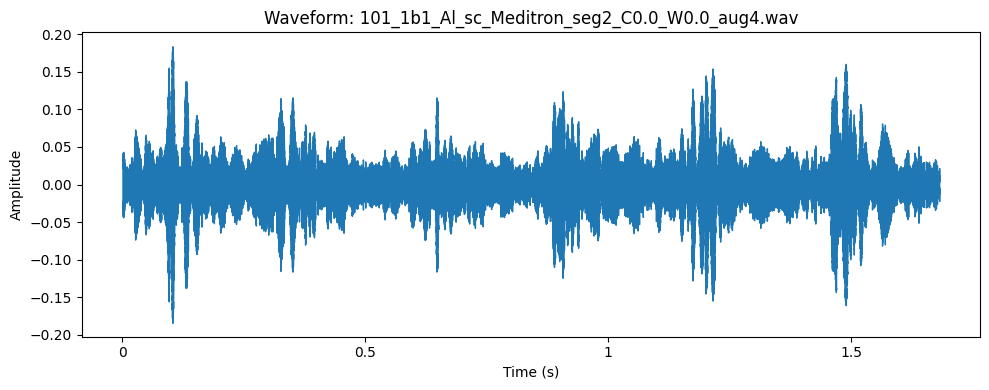

Visualizing: 101_1b1_Al_sc_Meditron_seg2_C0.0_W0.0.wav


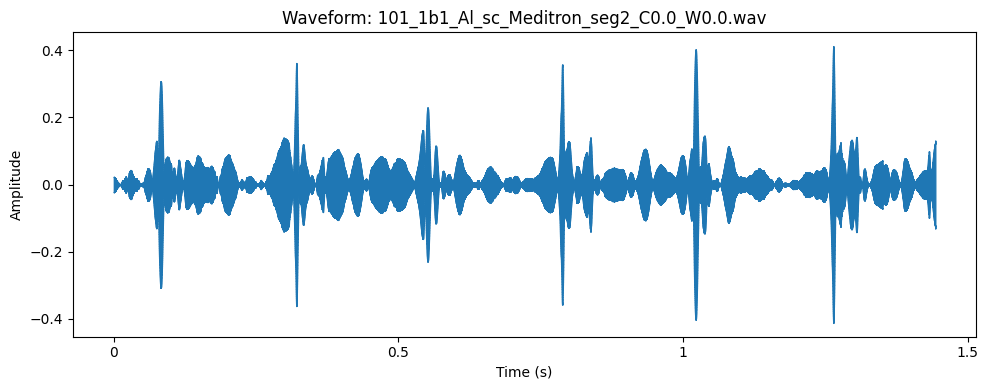

Visualizing: 208_1b1_Ll_sc_Meditron_seg5_C0.0_W0.0_aug1.wav


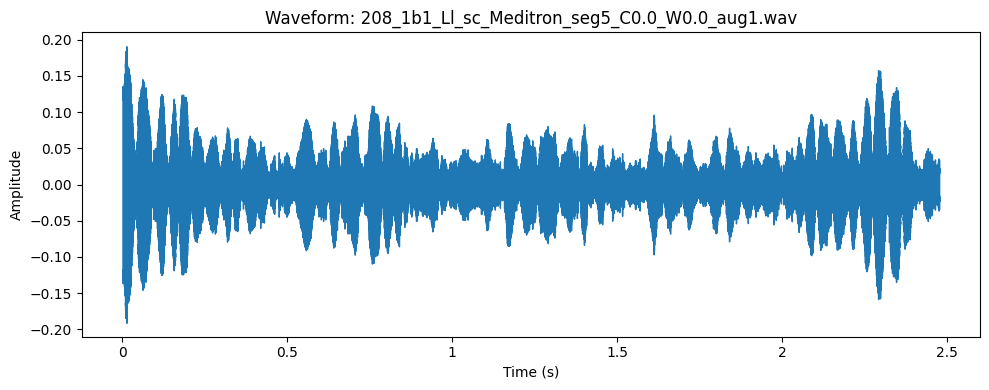

Visualizing: 208_1b1_Ll_sc_Meditron_seg5_C0.0_W0.0.wav


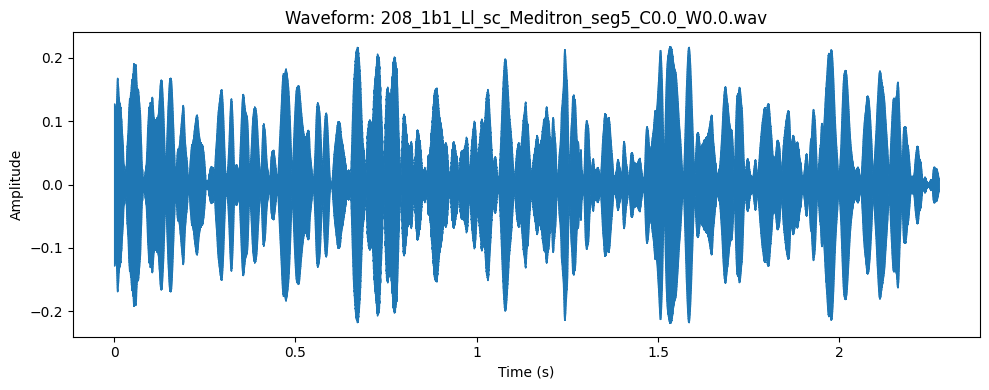

Visualizing: 107_2b3_Tc_mc_AKGC417L_seg3_C1.0_W0.0.wav


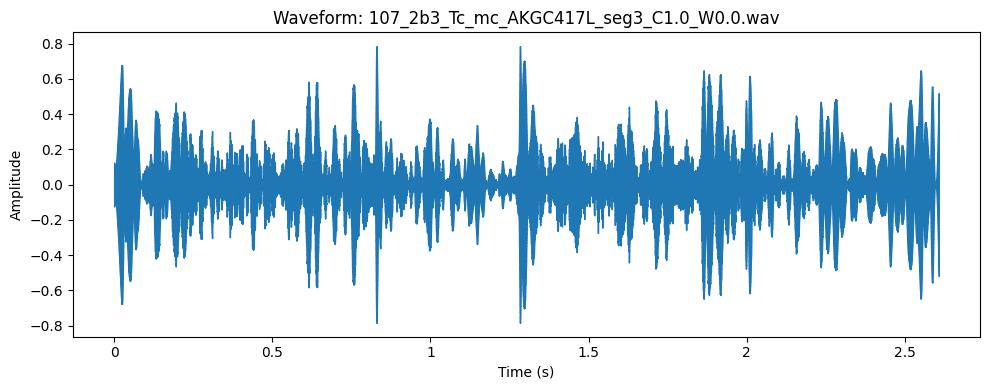

Visualizing: 130_3p4_Pl_mc_AKGC417L_seg3_C1.0_W1.0.wav


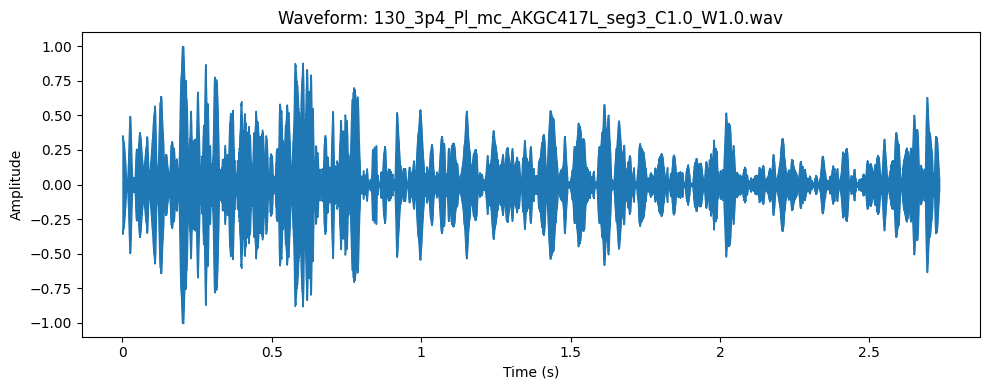

Visualizing: 138_2p2_Tc_mc_AKGC417L_seg2_C1.0_W0.0.wav


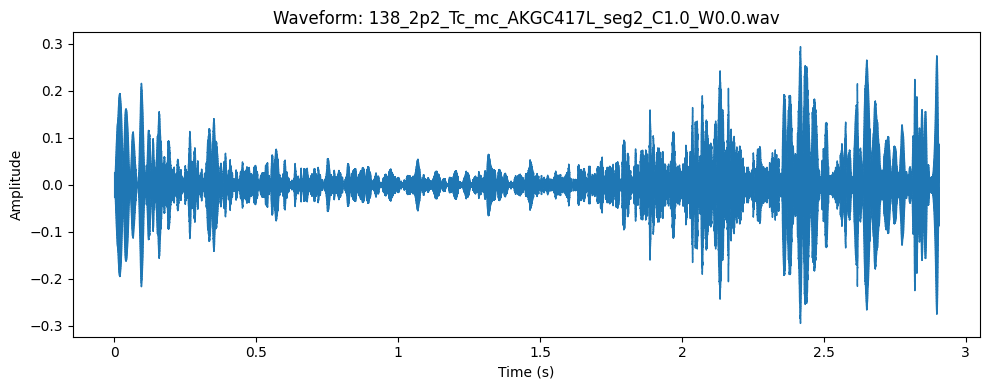

Visualizing: 140_2b3_Tc_mc_LittC2SE_seg2_C0.0_W1.0_aug5.wav


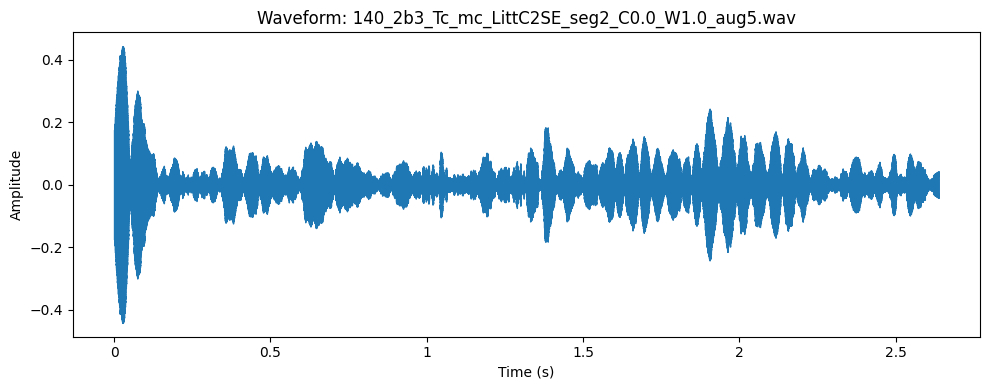

Visualizing: 140_2b3_Tc_mc_LittC2SE_seg2_C0.0_W1.0_aug1.wav


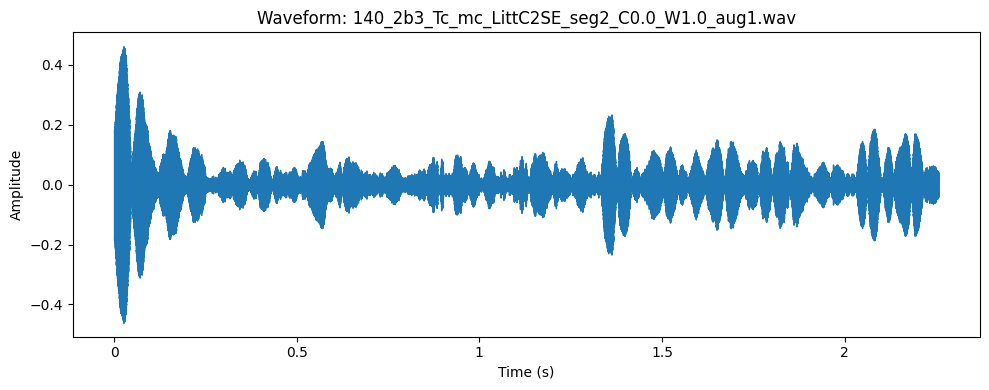

Visualizing: 140_2b3_Tc_mc_LittC2SE_seg2_C0.0_W1.0.wav


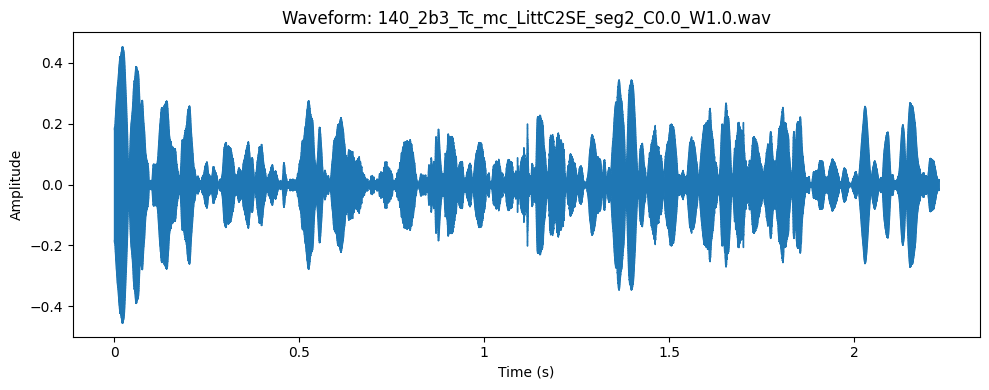

In [28]:
def show_audio(audio_path):
    """
    Visualize the waveform of an audio file.
    """
    y, sr = librosa.load(audio_path)
    
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform: {os.path.basename(audio_path)}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# List of specific files to visualize
files_to_visualize = [
    "101_1b1_Al_sc_Meditron_seg2_C0.0_W0.0_aug4.wav",
    "101_1b1_Al_sc_Meditron_seg2_C0.0_W0.0.wav",
    "208_1b1_Ll_sc_Meditron_seg5_C0.0_W0.0_aug1.wav",
    "208_1b1_Ll_sc_Meditron_seg5_C0.0_W0.0.wav",
    "107_2b3_Tc_mc_AKGC417L_seg3_C1.0_W0.0.wav",
    "130_3p4_Pl_mc_AKGC417L_seg3_C1.0_W1.0.wav",
    "138_2p2_Tc_mc_AKGC417L_seg2_C1.0_W0.0.wav",
    "140_2b3_Tc_mc_LittC2SE_seg2_C0.0_W1.0_aug5.wav",
    "140_2b3_Tc_mc_LittC2SE_seg2_C0.0_W1.0_aug1.wav",
    "140_2b3_Tc_mc_LittC2SE_seg2_C0.0_W1.0.wav"

]

# Directory containing the audio files
audio_dir = r'C:\Users\Jiary\Documents\GitHub\ML\Final_Audio_Dataset'

# Visualize the selected files
for file_name in files_to_visualize:
    file_path = os.path.join(audio_dir, file_name)
    if os.path.exists(file_path):
        print(f"Visualizing: {file_name}")
        show_audio(file_path)
    else:
        print(f"File not found: {file_name}")

In [29]:
def augment_class(audio_dir, output_dir, disease_files, num_files_to_augment=10, log_file='augmented_audio_log.json'):
    os.makedirs(output_dir, exist_ok=True)
    
    if os.path.exists(log_file):
        with open(log_file, 'r') as f:
            augmented_files = json.load(f)
    else:
        augmented_files = []
    
    files_to_augment = [f for f in disease_files if f not in augmented_files]
    selected_files = random.sample(files_to_augment, min(len(files_to_augment), num_files_to_augment))
    
    for file_path in tqdm(selected_files, desc=f"Augmenting"):
        for aug_id in range(1, 6):
            output_path = augment_audio(file_path, output_dir, augmentation_id=aug_id)
            if output_path:
                augmented_files.append(file_path)

    with open(log_file, 'w') as f:
        json.dump(augmented_files, f)

minority_classes = ["Bronchiectasis", "Pneumonia", "Bronchiolitis", "URTI", "Healthy"]
for disease in minority_classes:
    print(f"Augmenting {disease}...")
    augment_class(audio_dir, output_audio_dir, disease_files[disease], num_files_to_augment=50)


Augmenting Bronchiectasis...


Augmenting:  64%|██████▍   | 32/50 [00:43<00:12,  1.49it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\201_1b1_Ar_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\201_1b1_Ar_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\201_1b1_Ar_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\201_1b1_Ar_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\201_1b1_Ar_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.


Augmenting:  74%|███████▍  | 37/50 [00:46<00:08,  1.62it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\201_1b2_Al_sc_Meditron_seg6_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\201_1b2_Al_sc_Meditron_seg6_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\201_1b2_Al_sc_Meditron_seg6_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\201_1b2_Al_sc_Meditron_seg6_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\201_1b2_Al_sc_Meditron_seg6_C0.0_W0.0.wav: File too short.


Augmenting: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


Augmenting Pneumonia...


Augmenting:  16%|█▌        | 8/50 [00:04<00:21,  1.96it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\135_2b3_Pr_mc_LittC2SE_seg8_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\135_2b3_Pr_mc_LittC2SE_seg8_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\135_2b3_Pr_mc_LittC2SE_seg8_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\135_2b3_Pr_mc_LittC2SE_seg8_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\135_2b3_Pr_mc_LittC2SE_seg8_C0.0_W0.0.wav: File too short.


Augmenting:  22%|██▏       | 11/50 [00:05<00:16,  2.41it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\135_2b1_Ar_mc_LittC2SE_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\135_2b1_Ar_mc_LittC2SE_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\135_2b1_Ar_mc_LittC2SE_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\135_2b1_Ar_mc_LittC2SE_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\135_2b1_Ar_mc_LittC2SE_seg0_C0.0_W0.0.wav: File too short.


Augmenting:  54%|█████▍    | 27/50 [00:12<00:11,  1.92it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\191_2b1_Pr_mc_LittC2SE_seg7_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\191_2b1_Pr_mc_LittC2SE_seg7_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\191_2b1_Pr_mc_LittC2SE_seg7_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\191_2b1_Pr_mc_LittC2SE_seg7_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\191_2b1_Pr_mc_LittC2SE_seg7_C0.0_W0.0.wav: File too short.


Augmenting:  60%|██████    | 30/50 [00:13<00:09,  2.12it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\226_1b1_Pl_sc_LittC2SE_seg10_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\226_1b1_Pl_sc_LittC2SE_seg10_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\226_1b1_Pl_sc_LittC2SE_seg10_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\226_1b1_Pl_sc_LittC2SE_seg10_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\226_1b1_Pl_sc_LittC2SE_seg10_C0.0_W0.0.wav: File too short.


Augmenting:  64%|██████▍   | 32/50 [00:14<00:06,  2.63it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\219_2b2_Tc_mc_LittC2SE_seg5_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\219_2b2_Tc_mc_LittC2SE_seg5_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\219_2b2_Tc_mc_LittC2SE_seg5_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\219_2b2_Tc_mc_LittC2SE_seg5_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\219_2b2_Tc_mc_LittC2SE_seg5_C0.0_W0.0.wav: File too short.


Augmenting: 100%|██████████| 50/50 [00:22<00:00,  2.25it/s]


Augmenting Bronchiolitis...


Augmenting:  14%|█▍        | 7/50 [00:02<00:14,  3.00it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Al_sc_Meditron_seg17_C0.0_W1.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Al_sc_Meditron_seg17_C0.0_W1.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Al_sc_Meditron_seg17_C0.0_W1.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Al_sc_Meditron_seg17_C0.0_W1.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Al_sc_Meditron_seg17_C0.0_W1.0.wav: File too short.


Augmenting:  20%|██        | 10/50 [00:03<00:12,  3.33it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\161_1b1_Al_sc_Meditron_seg8_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\161_1b1_Al_sc_Meditron_seg8_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\161_1b1_Al_sc_Meditron_seg8_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\161_1b1_Al_sc_Meditron_seg8_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\161_1b1_Al_sc_Meditron_seg8_C0.0_W0.0.wav: File too short.


Augmenting:  36%|███▌      | 18/50 [00:05<00:10,  3.07it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\206_1b1_Ar_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\206_1b1_Ar_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\206_1b1_Ar_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\206_1b1_Ar_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\206_1b1_Ar_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Pl_sc_Meditron_seg14_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Pl_sc_Meditron_seg14_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Pl_sc_Meditron_seg14_C0.0_W0.0.wav: File too shor

Augmenting:  72%|███████▏  | 36/50 [00:11<00:04,  3.15it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Lr_sc_Meditron_seg5_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Lr_sc_Meditron_seg5_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Lr_sc_Meditron_seg5_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Lr_sc_Meditron_seg5_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Lr_sc_Meditron_seg5_C0.0_W0.0.wav: File too short.


Augmenting:  80%|████████  | 40/50 [00:12<00:03,  2.51it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\167_1b1_Al_sc_Meditron_seg12_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\167_1b1_Al_sc_Meditron_seg12_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\167_1b1_Al_sc_Meditron_seg12_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\167_1b1_Al_sc_Meditron_seg12_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\167_1b1_Al_sc_Meditron_seg12_C0.0_W0.0.wav: File too short.


Augmenting:  84%|████████▍ | 42/50 [00:13<00:02,  3.14it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Al_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Al_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Al_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Al_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\149_1b1_Al_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.


Augmenting: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]


Augmenting URTI...


Augmenting:  30%|███       | 15/50 [00:06<00:13,  2.63it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\188_1b1_Pl_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\188_1b1_Pl_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\188_1b1_Pl_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\188_1b1_Pl_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\188_1b1_Pl_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.


Augmenting:  42%|████▏     | 21/50 [00:09<00:12,  2.36it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\150_1b2_Al_sc_Meditron_seg0_C1.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\150_1b2_Al_sc_Meditron_seg0_C1.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\150_1b2_Al_sc_Meditron_seg0_C1.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\150_1b2_Al_sc_Meditron_seg0_C1.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\150_1b2_Al_sc_Meditron_seg0_C1.0_W0.0.wav: File too short.


Augmenting:  46%|████▌     | 23/50 [00:09<00:08,  3.32it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\210_1b1_Al_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\210_1b1_Al_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\210_1b1_Al_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\210_1b1_Al_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\210_1b1_Al_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.


Augmenting:  56%|█████▌    | 28/50 [00:10<00:06,  3.37it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\148_1b1_Al_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\148_1b1_Al_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\148_1b1_Al_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\148_1b1_Al_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\148_1b1_Al_sc_Meditron_seg0_C0.0_W0.0.wav: File too short.


Augmenting:  86%|████████▌ | 43/50 [00:18<00:02,  2.68it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\210_1b1_Al_sc_Meditron_seg14_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\210_1b1_Al_sc_Meditron_seg14_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\210_1b1_Al_sc_Meditron_seg14_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\210_1b1_Al_sc_Meditron_seg14_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\210_1b1_Al_sc_Meditron_seg14_C0.0_W0.0.wav: File too short.


Augmenting:  92%|█████████▏| 46/50 [00:19<00:01,  3.52it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\150_1b2_Al_sc_Meditron_seg16_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\150_1b2_Al_sc_Meditron_seg16_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\150_1b2_Al_sc_Meditron_seg16_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\150_1b2_Al_sc_Meditron_seg16_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\150_1b2_Al_sc_Meditron_seg16_C0.0_W0.0.wav: File too short.


Augmenting: 100%|██████████| 50/50 [00:20<00:00,  2.49it/s]


Augmenting Healthy...


Augmenting:   4%|▍         | 2/50 [00:00<00:16,  2.94it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\217_1b1_Tc_sc_Meditron_seg10_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\217_1b1_Tc_sc_Meditron_seg10_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\217_1b1_Tc_sc_Meditron_seg10_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\217_1b1_Tc_sc_Meditron_seg10_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\217_1b1_Tc_sc_Meditron_seg10_C0.0_W0.0.wav: File too short.


Augmenting:  54%|█████▍    | 27/50 [00:12<00:10,  2.16it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\187_1b1_Ll_sc_Meditron_seg1_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\187_1b1_Ll_sc_Meditron_seg1_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\187_1b1_Ll_sc_Meditron_seg1_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\187_1b1_Ll_sc_Meditron_seg1_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\187_1b1_Ll_sc_Meditron_seg1_C0.0_W0.0.wav: File too short.


Augmenting:  58%|█████▊    | 29/50 [00:12<00:06,  3.02it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\187_1b1_Ll_sc_Meditron_seg8_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\187_1b1_Ll_sc_Meditron_seg8_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\187_1b1_Ll_sc_Meditron_seg8_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\187_1b1_Ll_sc_Meditron_seg8_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\187_1b1_Ll_sc_Meditron_seg8_C0.0_W0.0.wav: File too short.


Augmenting:  64%|██████▍   | 32/50 [00:14<00:08,  2.15it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\143_1b1_Al_sc_Meditron_seg14_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\143_1b1_Al_sc_Meditron_seg14_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\143_1b1_Al_sc_Meditron_seg14_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\143_1b1_Al_sc_Meditron_seg14_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\143_1b1_Al_sc_Meditron_seg14_C0.0_W0.0.wav: File too short.


Augmenting:  94%|█████████▍| 47/50 [00:21<00:01,  2.32it/s]

Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\123_1b1_Al_sc_Meditron_seg7_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\123_1b1_Al_sc_Meditron_seg7_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\123_1b1_Al_sc_Meditron_seg7_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\123_1b1_Al_sc_Meditron_seg7_C0.0_W0.0.wav: File too short.
Skipping C:\Users\Jiary\Documents\GitHub\ML\Processed_Audio_Files\123_1b1_Al_sc_Meditron_seg7_C0.0_W0.0.wav: File too short.


Augmenting: 100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


In [1]:
def show_audio(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(3,2,1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.waveshow(y_noise, sr=sr)
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.waveshow(y_shift, sr=sr)
    plt.title('shift')
    
    plt.subplot(3,2,4)
    librosa.display.waveshow(y_stretch_1, sr=sr)
    plt.title('stretch 1')

    plt.subplot(3,2,5)
    librosa.display.waveshow(y_stretch_2, sr=sr)
    plt.title('stretch 2')
    
    plt.subplot(3,2,6)
    librosa.display.waveshow(y_pitch_shift, sr=sr)
    plt.title('pitch shift')

    plt.tight_layout()